# Instalação e importação das bibliotecas

NLTK (natural language toolkit) é uma biblioteca muito utilizada em aplicações de PLN

Trata-se de um corpus linguístico muito popular na comunidade python.

#### Antes de qualquer coisa é preciso instalar o NLTK:

In [1]:
# EXECUTE O TRECHO ABAIXO NO TEMMINAL DO JUPYTER
# !conda install nltk

In [2]:
# IMPORT/DOWNLOAD DO NLTK
# AO EXECUTAR ESSE TRECHO, UMA JANELA SE ABRIRÁ, SELECIONE ALL E CONFIRME O DOWNLOAD (PODE DEMORAR UM POUCO)
# SE VOCÊ JÁ TEM NLTK BAIXADO, IGNORE A LINHA DE DOWNLOAD
import nltk
# nltk.download()

In [3]:
# IMPORTANDO DEMAIS BIBLIOTECAS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

# Obtendo os dados

Para exemplificar um pipeline básico de PLN vamos usar o dataset de mensagens (spam/não spam) da comunidade de machine learning da UCI (University of California, Irvine).

In [5]:
# ARQUIVO SEPARADO POR TABULAÇÃO (sep='\t')
ms = pd.read_csv('SPAM', sep='\t', names=['LABEL', 'MENSAGEM'])
ms.head()

,LABEL,MENSAGEM
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# CRIANDO UMA VARIÁVEL COM O TAMANHO DA MENSAGEM
ms['TAMANHO_MS'] = ms['MENSAGEM'].apply(len)

# CRIANDO UMA VARIÁVEL COM A QUANTIDADE TOTAL DE PALAVRAS DA MENSAGEM
ms['TOT_PALAVRAS'] = ms['MENSAGEM'].str.split().str.len()

ms.head()

,LABEL,MENSAGEM,TAMANHO_MS,TOT_PALAVRAS
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13


# Análise exploratória inicial

Verificando o balanceamento da amostra, percentualmente:

In [7]:
(ms[ms['LABEL'] == 'spam']['LABEL'].count() / ms['LABEL'].count())*100

13.406317300789663

Distribuição de tamanho das mensagens

Pelo visto abaixo, em geral spams carregam mensagens maiores!

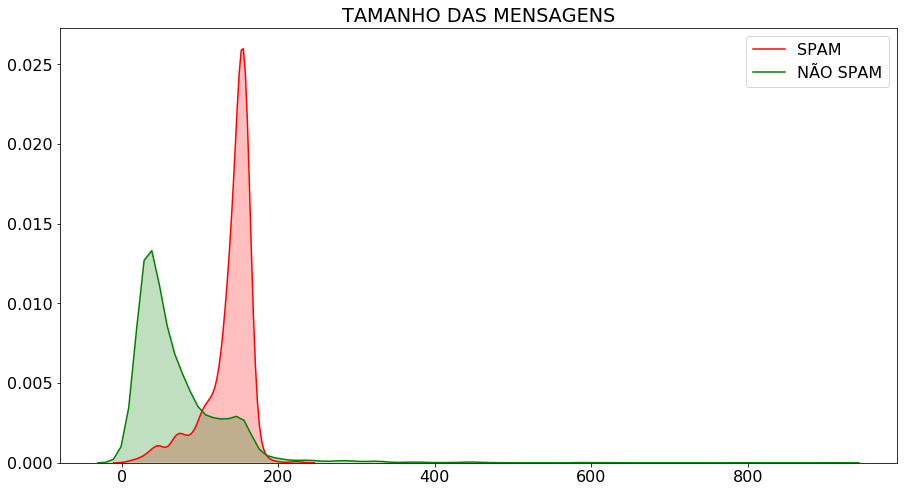

In [8]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,8))
sns.kdeplot(ms[ms['LABEL'] == 'spam']['TAMANHO_MS'], shade=True,label='SPAM', color='r').set_title('TAMANHO DAS MENSAGENS')
sns.kdeplot(ms[ms['LABEL'] == 'ham']['TAMANHO_MS'], shade=True, label='NÃO SPAM', color='g')

# Preparação de dados para mineração de texto

## Tratando as pontuações e stopwords

Vamos criar uma função que retire pontuações e stopwords.

Além disso, na mesma função, vamos normalizar as palavras: tratamento das flexões (sufixos/prefixos), plurais, etc.

Para pontuação a classe string do python possui um atributo chamado punctuation (basicamente é uma string de pontuações).

Para os stopwords, corpus NLTK possui uma lista completa de palavras vazias (do inglês e outros idiomas).

Na normalização vamos usar um método PorterStemmer da biblioteca stem.

In [9]:
# IMPORTANDO STRING (PARA PONTUAÇÕES)
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
# IMPORTANDO OS STOPWORDS
from nltk.corpus import stopwords
# 5 EXEMPLOS DE STOP WORDS DO INGLÊS
stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

In [11]:
# IMPORTANDO A BIBLIOTECA PORTER STEMMER
# VAMOS USA-LA PARA NORMALIZAR (STEMMING) OS TERMOS
from nltk.stem import PorterStemmer 

In [12]:
# FUNÇÃO QUE APLICA AS TRANSFORMAÇÕES NO TEXTO
def transfTexto(msg):
    
    # PARA CADA CARACTERE DA MENSAGEM FILTRA PONTUAÇÕES (not in string.punctuation)
    semPont = [char for char in msg if char not in string.punctuation]

    # JUNTA OS CARACTERES NOVAMENTE
    semPont = ''.join(semPont)
    
    # REMOVE STOP WORDS
    remStWords = [palavra for palavra in semPont.split() if palavra.lower() 
                  not in stopwords.words('english')]
    
    # NORMALIZA POR STEMMING E RETORNA O RESULTADO
    st = PorterStemmer()
    return [st.stem(stPalavra) for stPalavra in remStWords]


In [13]:
# APLICANDO A FUNÇÃO DE TRANSFORMAÇÃO
ms['MENSAGEM'].apply(transfTexto).head()

0    [Go, jurong, point, crazi, avail, bugi, n, gre...
1                         [Ok, lar, joke, wif, u, oni]
2    [free, entri, 2, wkli, comp, win, FA, cup, fin...
3        [U, dun, say, earli, hor, U, c, alreadi, say]
4    [nah, dont, think, goe, usf, live, around, tho...
Name: MENSAGEM, dtype: object

In [14]:
ms

,LABEL,MENSAGEM,TAMANHO_MS,TOT_PALAVRAS
0,ham,"Go until jurong point, crazy.. Available only ...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,32
6,ham,Even my brother is not like to speak with me. ...,77,16
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,26
8,spam,WINNER!! As a valued network customer you have...,157,26
9,spam,Had your mobile 11 months or more? U R entitle...,154,29


## Vetorização do texto (Word Count)
#### Passo 1: vetorizar
A partir desse ponto, vamos peparar as mensagens para que fiquem apropriadas para tarefas de ML.

Vamos usar a biblioteca feature_extraction do sklearn.

Nessa biblioteca encontramos a classe CountVectorizer. Essa classe implementa a vetorização Word Count.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

Como quase tudo no sklearn segue o pipeline fit/transform, aqui não é diferente.

É preciso fitar um objeto a partir dos dados e na sequência usar esse objeto para transformar os dados que queremos.

Vamos criar um objeto CountVectorizer chamado msVet a partir das mensagens. Depois usaremos esse mesmo objeto para transformar as mensagens.

In [15]:
# FITANDO UM OBJETO VETORIZADOR DE WORDCOUNT
vetorizadorWC = CountVectorizer(analyzer=transfTexto).fit(ms['MENSAGEM'])

In [16]:
# VETORIZANDO AS MENSAGENS
msVetWC = vetorizadorWC.transform(ms['MENSAGEM'])

Agora a nossa matriz esparsa usando wordcount sobre as mensagens.

Ela se chama msVet, e tem 5K linhas por 11K colunas

msVet não é visível no jupyter pois é um objeto compactado. Mas acredite, ele está lá...

In [17]:
msVetWC.shape

(5572, 8309)

#### Passo 2: criando o DF para aplicação de ML
Nossa variável de desfecho (LABEL) não está no objeto vetorizado.

Precisamos unir as coisas agora, uma vez que o desfecho é a variável que vamos usar para a classificação (spam/não spam).

O bloco abaixo une a matriz esparsa (vetorizada) com o LABEL das mensagens.

In [18]:
# PRIMEIRO É PRECISO TRANSFORMAR EM DATAFRAME A MATRIZ ESPARSA (OBJETO COMPACTADO)
msVetWCPandas = pd.DataFrame(msVetWC.todense(), columns=vetorizadorWC.get_feature_names())

# CONCATENANDO... (msWC = MENSAGENS USANDO WORD COUNT)
msWC = pd.concat([ms['LABEL'], msVetWCPandas], axis=1)

msWC.head()

,LABEL,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,»10,Ü,é,ü,üll,–,“,“harri,…,…thank
0,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Vetorização do texto para TF-IDF
#### Passo 1: vetorizar

Idem a vetorização que fizemos a partir do word count, agora vamos criar uma nova vetorização baseada em TF-IDF.

Sklearn possui uma biblioteca específica para TF-IDF, chamada TfidfTransformer.

A dinâmica aqui é a mesma que vimos em Word Count, a diferença é que para calcularmos TF-IDF utilizamos a matriz espasa de Word Cound como input.

Sim! É preciso vetorizar por Word Count para depois aplicar TF-IDF!...

O pipeline é semelhante:

- Fitamos um objeto CountVectorizer

- Criamos um novo objeto (matriz esparsa) transformando os dados com o objeto fitado.

- Convertemos a matriz esparsa (vetorizada) para um frame pandas, para que possamos seguir trabalhando...


In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

# CRIANDO O OBJETO VETORIZADOR
vetorizadorTFIDF = TfidfTransformer().fit(msVetWC)

# VETORIZANDO...
msVetTFIDF = vetorizadorTFIDF.transform(msVetWC)

# FORMATO
msVetTFIDF.shape

(5572, 8309)

Pronto! Agora temos um falor de TF-IDF para cada termo para cada bow do corpus.

Seguimos em frente...

#### Passo 2: criando o DF para aplicação de ML
Nossa variável de desfecho (LABEL) não está no objeto vetorizado.

Precisamos unir as coisas agora, uma vez que o desfecho é a variável que vamos usar para a classificação (spam/não spam).

O bloco abaixo une a matriz esparsa (vetorizada) com o LABEL das mensagens.

In [24]:
# PRIMEIRO É PRECISO TRANSFORMAR EM DATAFRAME A MATRIZ ESPARSA (OBJETO COMPACTADO)
msVetTFIDFPandas = pd.DataFrame(msVetTFIDF.todense(), columns=vetorizadorWC.get_feature_names())

# CONCATENANDO... (msTFIDF = MENSAGENS USANDO TFIDF)
msTFIDF = pd.concat([ms['LABEL'], msVetTFIDFPandas], axis=1)

msTFIDF.head()

,LABEL,0,008704050406,0089mi,0121,01223585236,01223585334,0125698789,02,020603,...,»10,Ü,é,ü,üll,–,“,“harri,…,…thank
0,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Adicionalmente, podemos visualizar os resultados de TF-IDF de cada termo em relação a todo o corpus:

In [21]:
# DEFINIMOS COMO INDICE OS TERMOS (BUSCAMOS DO OBJETO TREINADO ANTERIORMENTE NO WC)
# msTFIDF = pd.DataFrame(vetorizadorTFIDF.idf_, index=vetorizadorWC.get_feature_names(),columns=['TF-IDF'])
 
# TEMOS UM VALORE DE TF-IDF PARA CADA TEMRO DISTINTO DO CORPUS...
# msTFIDF.sort_values(by=['TF-IDF'], ascending = False).head()

,TF-IDF
…thank,8.932542
hellohow,8.932542
hersh,8.932542
heron,8.932542
heroi,8.932542


### Pronto!!
Agora temos dois datasets prontos para iniciar os trabalhos de ML: um WC (msWC) e outro TF-IDF (msTFIDF).

Obviamente o dataset vetorizado construído por WC resultará em um modelo inferior em relação ao TF-IDF. Será mesmo?

Nesse contexto, nossa objetivo é criar um fitro de spams, vamos em frente?..

-----------------------------

In [25]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(msTFIDF.drop('LABEL', axis=1),msTFIDF['LABEL'],test_size=0.3)

In [ ]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

In [26]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(ms['MENSAGEM'],ms['LABEL'],test_size=0.3)

In [27]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [28]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(ms['MENSAGEM'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [29]:
print(Tfidf_vect.vocabulary_)

{'go': 1751, 'until': 4373, 'point': 3020, 'crazy': 1133, 'available': 612, 'only': 2755, 'in': 2003, 'bugis': 836, 'great': 1790, 'world': 4837, 'la': 2197, 'buffet': 835, 'cine': 989, 'there': 4147, 'got': 1775, 'wat': 4613, 'ok': 2740, 'lar': 2211, 'joking': 2123, 'wif': 4739, 'oni': 2752, 'free': 1644, 'entry': 1433, 'wkly': 4795, 'comp': 1052, 'to': 4212, 'win': 4752, 'fa': 1506, 'cup': 1156, 'final': 1575, 'tkts': 4203, '21st': 171, 'may': 2441, '2005': 166, 'text': 4123, '87121': 355, 'receive': 3355, 'question': 3294, 'std': 3902, 'txt': 4306, 'rate': 3324, 'apply': 551, '08452810075over18': 41, 'dun': 1366, 'say': 3528, 'so': 3776, 'early': 1374, 'hor': 1927, 'already': 495, 'then': 4145, 'nah': 2618, 'don': 1317, 'think': 4155, 'he': 1857, 'goes': 1757, 'usf': 4419, 'lives': 2292, 'around': 574, 'here': 1883, 'though': 4166, 'freemsg': 1648, 'hey': 1887, 'darling': 1184, 'it': 2074, 'been': 680, 'week': 4660, 'now': 2704, 'and': 513, 'no': 2678, 'word': 4828, 'back': 635, 'li

In [30]:
print(Train_X_Tfidf)

  (0, 4712)	0.4743369135422784
  (0, 4020)	0.4003732612163398
  (0, 3908)	0.43405505660324645
  (0, 3692)	0.3666914658294331
  (0, 3528)	0.24907958431772037
  (0, 2704)	0.16753473706111296
  (0, 2681)	0.31979571528177364
  (0, 943)	0.3153751637662454
  (1, 4701)	0.23788010241640084
  (1, 4140)	0.31979217319238773
  (1, 3414)	0.4778137685428231
  (1, 2991)	0.532429864582888
  (1, 2727)	0.19753034976939576
  (1, 2703)	0.5082618570771958
  (1, 2065)	0.17891369509019084
  (2, 4963)	0.10305597938307555
  (2, 4677)	0.1534659868302365
  (2, 4214)	0.24360000150616487
  (2, 4085)	0.25427278795038033
  (2, 3930)	0.24360000150616487
  (2, 3782)	0.23936443053783982
  (2, 3732)	0.23936443053783982
  (2, 3495)	0.20727678905652355
  (2, 3005)	0.24360000150616487
  (2, 2995)	0.21029999597910984
  :	:
  (3898, 3744)	0.5653110289841616
  (3898, 2672)	0.3265215975528061
  (3898, 2611)	0.21252466710152723
  (3898, 1765)	0.27647867828136496
  (3898, 1202)	0.3253270427850861
  (3898, 902)	0.3528023428564011

In [31]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  96.5909090909091


In [32]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  98.6244019138756
